# Example: Deprojection, gas density profiles and gas masses #

This thread shows how to use _PyProffit_ to extract gas density profiles, gas masses, integrated count rates and luminosities from imaging data. This code implements the method presented in Eckert et al. (2020) to apply deprojection and PSF deconvolution. 

We start by loading the data and extracting a profile...

In [1]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt

In [2]:
import os

# Change this to the proper directory containing the test data
os.chdir('../../validation/')

Let's load the data into a [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) structure...

In [3]:
dat=pyproffit.Data(imglink='b_37.fits.gz',explink='expose_mask_37.fits.gz',
                   bkglink='back_37.fits.gz')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Now we extract a profile in circular annuli from the surface brightness peak...

Determining X-ray peak
Coordinates of surface-brightness peak: 272.0 281.0
Corresponding FK5 coordinates:  55.72147733144434 -53.628226297404545


<Figure size 432x288 with 0 Axes>

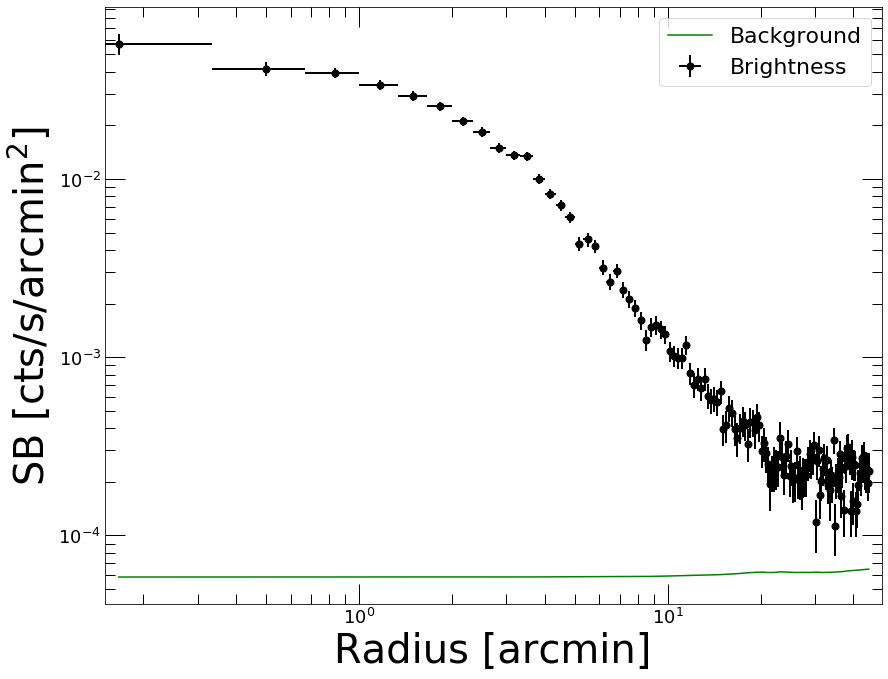

In [4]:
prof=pyproffit.Profile(dat,center_choice='peak',maxrad=45.,binsize=20.)

prof.SBprofile()

prof.Plot()

## PSF modeling ##

To correct for PSF smearing, we need to create a PSF mixing matrix which describes the leaking of photons from each annulus to the others. The shape of the PSF needs to be known a priori. The definition of the PSF can be done either by providing an input image or through an analytical function. 

In the following example we model the ROSAT/PSPC PSF as a King function with a core radius of 25 arcsec

In [5]:
def fking(x):
    r0=25./60. # arcmin
    alpha=1.5 # King slope
    return np.power(1. + (x/r0) ** 2, -alpha)


Now we pass this function to the [PSF](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile.PSF) method of the [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) class. To create the mixing matrix, the method creates normalized images of each annulus individually, convolves them with the PSF using FFT and computes the fraction of events in the FFT-convolved image that fall within each annulus. See Eckert et al. (2020) for more details.

In [6]:
prof.PSF(psffunc = fking)

Let's inspect the PSF mixing matrix. Each row describes the fraction originating from that annulus which are in fact recorded in any other row

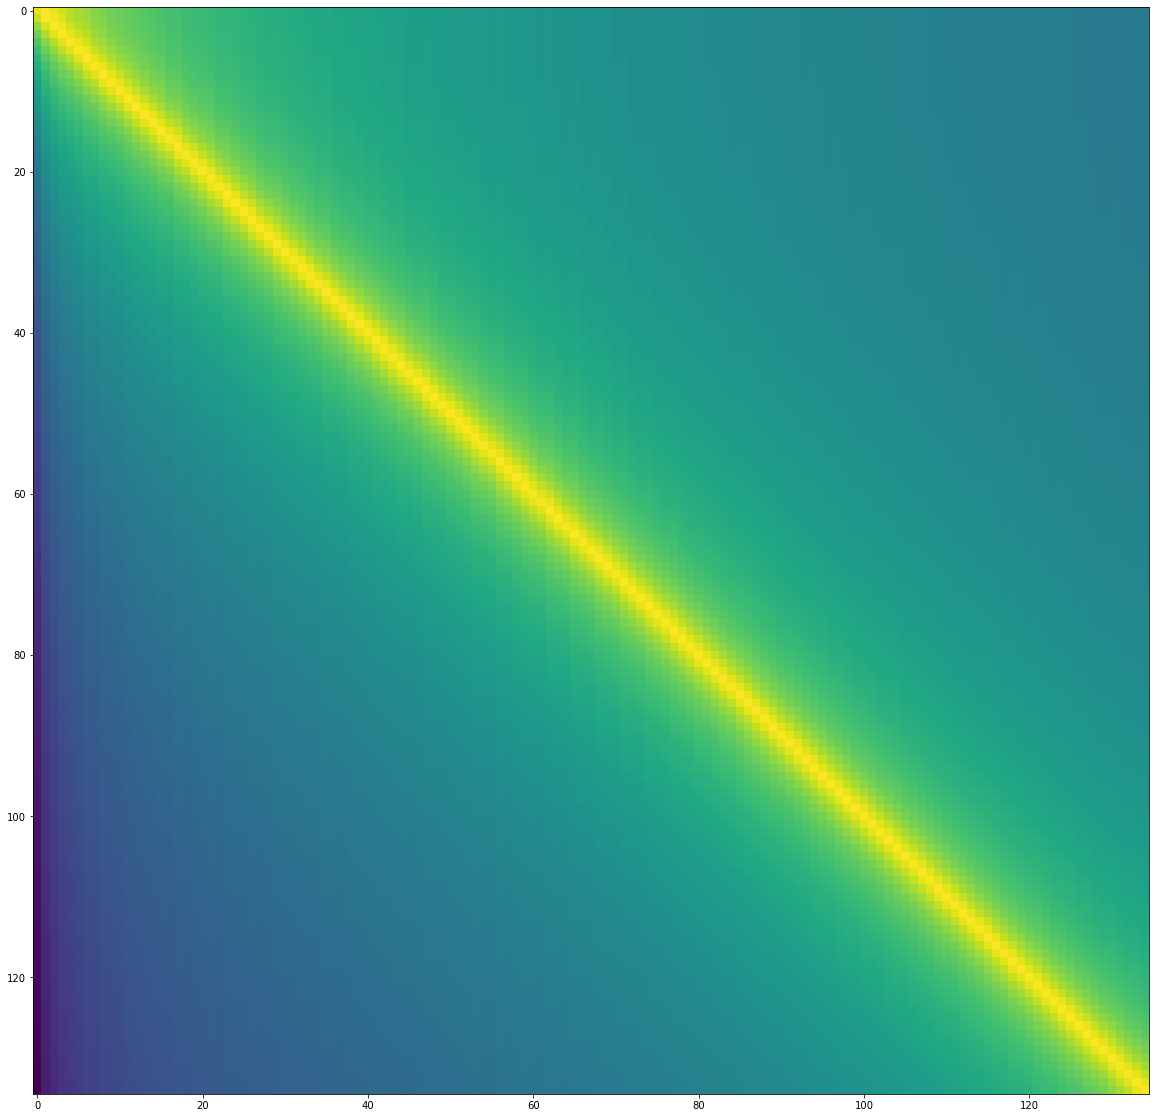

In [7]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log10(prof.psfmat), aspect='auto')

## Deprojection ##

For deprojection, PyProffit implements both the standard onion-peeling deprojection similar to that of plain Proffit and a new method based on multiscale decomposition of the observed profile. The new method is suitable in the low count-rate regime, provides on-the-fly propagation of the background value and PSF deconvolution.

The two methods can be accessed with the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class. For the extraction of density profiles the class requires the following input:
    - profile=prof: a Profile object containing the data
    - z=redshift: the redshift of the source
    - cf=factor: the conversion between count rate and emission measure

The conversion factor can be computed using the [calc_emissivity](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.emissivity.calc_emissivity) function, which goes through XSPEC to simulate an absorbed APEC model with an emission measure of 1 and retrieve the corresponding count rate. XSPEC needs to be accessible in the PATH for this command to work properly

In [8]:
z_a3158 = 0.059 # Source redshift, here 0.059 for the test cluster A3158
kt_a3158 = 5.0 # Plasma temperature; if a soft band is used the profile is mildly dependent on it
nh_a3158 = 0.0118 # Source NH in 1e22 cm**(-2) unit
rsp = 'pspcb_gain2_256.rsp' # Response file, here ROSAT/PSPC in RSP format
elow = 0.42 # Lower energy boundary of the image
ehigh = 2.01 # Upper energy boundary of the image

cf = prof.Emissivity(z=z_a3158,
                    kt=kt_a3158,
                    nh=nh_a3158,
                    rmf=rsp,
                    elow=elow,
                    ehigh=ehigh)

print(cf)


45.91


We are now ready to declare the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) object. Note that in case the redshift and conversion factor are not known, it is still possible to run the PSF deconvolution and profile reconstruction, however the gas density profile and gas mass cannot be computed.

In [9]:
depr = pyproffit.Deproject(z=z_a3158, cf=cf, profile=prof)

Let's start with the multiscale decomposition method. It can be launched with the [Multiscale](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Multiscale) method of the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class. The parameters of the method are the following:

    - backend='pymc3': choose whether the optimization will be performed with the PyMC3 or the Stan backend
    - nmcmc=1000: number of points in Hamiltonian Monte Carlo chain
    - bkglim=rad: radius beyond which it is assumed that the source is 0 (i.e. background only)
    - samplefile=file.dat: output file where the HMC samples will be stored
    
The sampling time with HMC will depend on a number of factors, including the number of bins in the profile, the number of points in the output chain, and the bkglim value.

In [10]:
depr.Multiscale(nmcmc=1000, bkglim=30.)

Running MCMC...


logp = -964.14, ||grad|| = 0.31003: 100%|██████████| 296/296 [00:00<00:00, 2174.12it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bkg, coefs]
Sampling 4 chains, 292 divergences: 100%|██████████| 6000/6000 [04:09<00:00, 24.01draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7156662359961405, but should be close to 0.8. Try to increase the number of tuning steps.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight pro

Done.
 Total computing time is:  4.245262555281321  minutes


The quality of the restruction can be viewed through the [PlotSB](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.PlotSB) method of the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class

<Figure size 432x288 with 0 Axes>

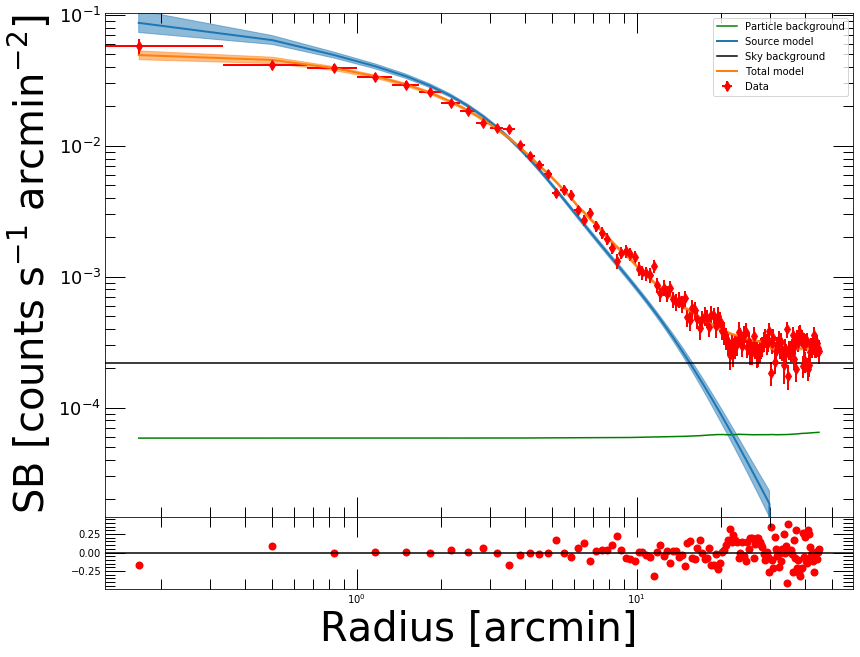

In [11]:
depr.PlotSB()

Here the total model (PSF convolved source + background) is shown in orange. The reconstructed source profile (PSF deconvolved) is shown in blue, and the fitted sky background is in black. The residuals (bottom panel) allow the user to assess the quality of the reconstruction.

## Count Rates and luminosities ##

The count rates can be computed easily from the reconstructed surface brightness profile within any user given apertures. This is done through the [CountRate](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.CountRate) method, which integrates the PSF deconvolved model over the area. The posterior distribution of the count rate can be displayed as well.

Reconstructed count rate: 2.01276 (1.97806 , 2.04665)


<Figure size 432x288 with 0 Axes>

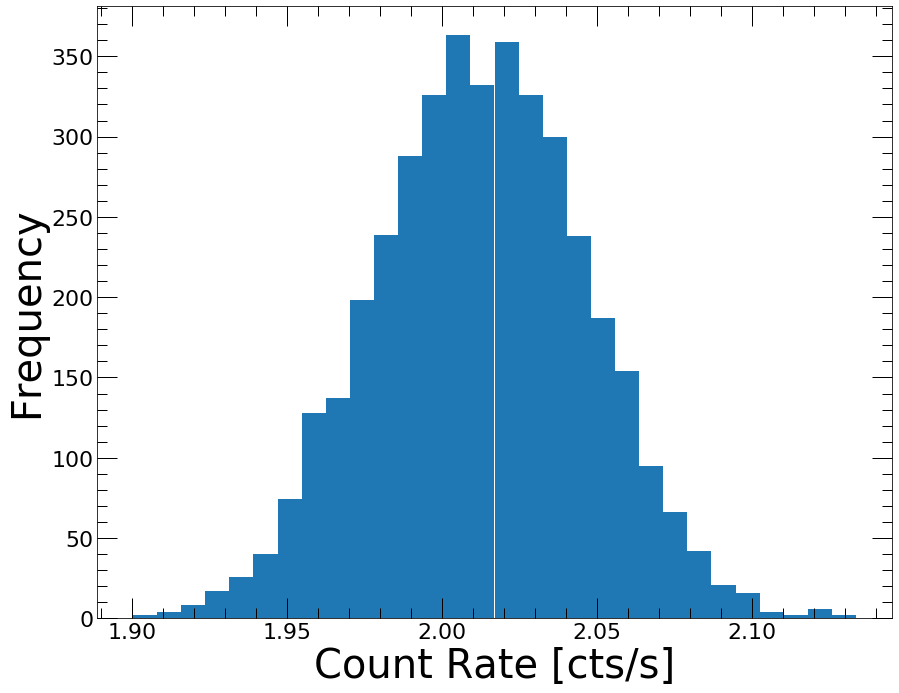

In [12]:
cr, cr_lo, cr_hi = depr.CountRate(0., 30.)

And the luminosity can be obtained similarly through the [Luminosity](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Luminosity) method. Similarly to the gas density, the luminosity requires the emissivity conversion to be calculated

Reconstructed luminosity: 1.95077e+44 (1.91713e+44 , 1.98361e+44)


<Figure size 432x288 with 0 Axes>

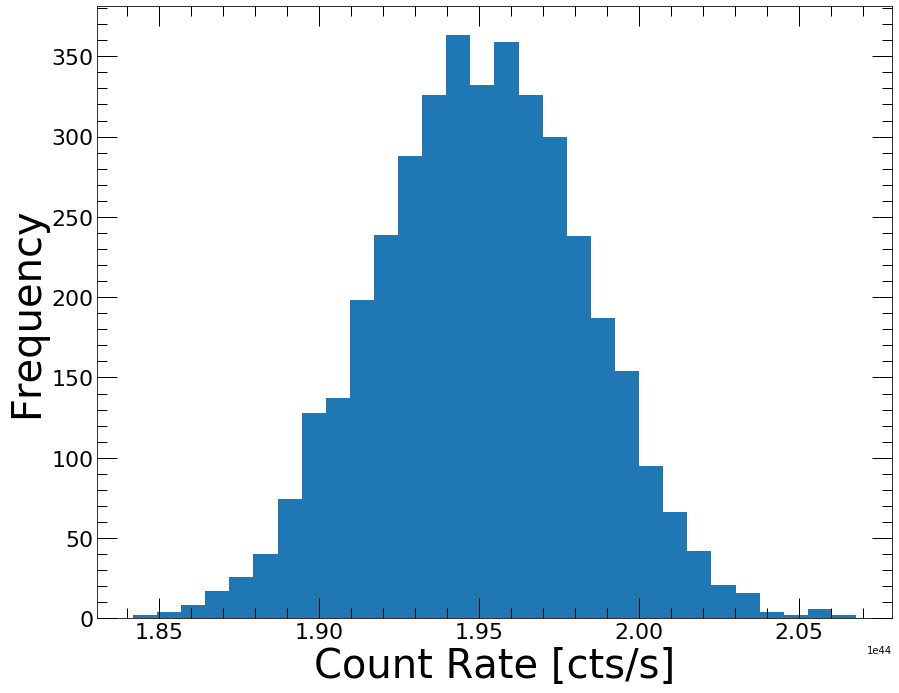

In [13]:
lum, lum_lo, lum_hi = depr.Luminosity(0., 30.)

## Gas density profile ##

Once a [Multiscale](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Multiscale) reconstruction has been performed, and if the source redshift and the emission measure conversion factor have been provided, it is straightforward to measure the gas density profile of the source. This is done through the [Density](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Density) method of the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class. The gas density profile can then be plotted through the [PlotDensity](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.PlotDensity) method

<Figure size 432x288 with 0 Axes>

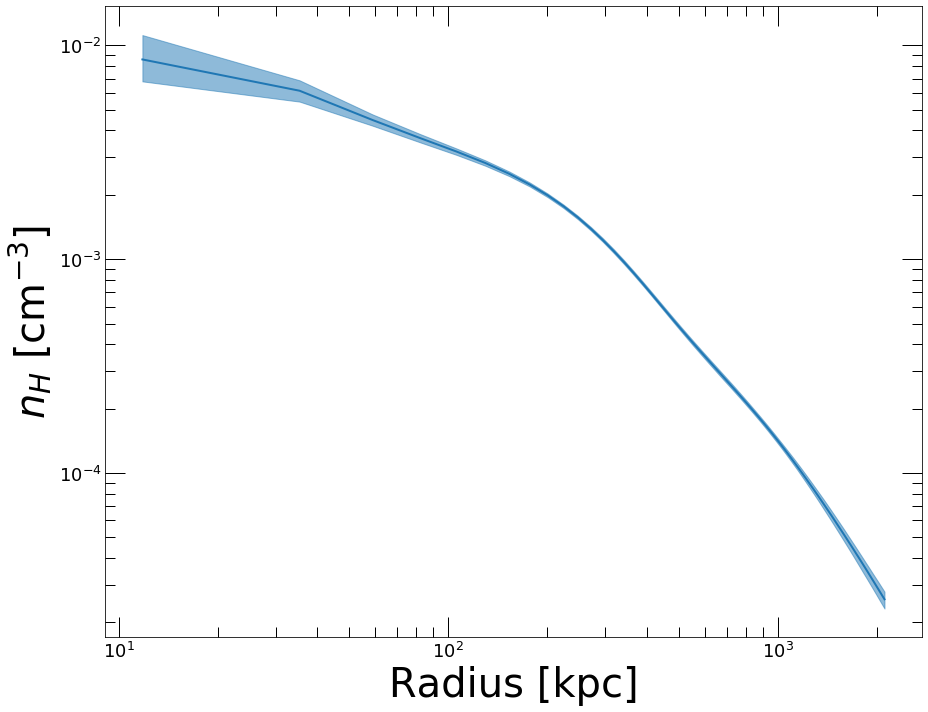

In [14]:
depr.Density()

depr.PlotDensity()

## Onion Peeling deprojection ##

If instead of the multiscale approach one wishes to compute the deprojected profile using the classical _onion peeling_ approach, in which case the projection kernel is directly inverted, the [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class contains the [OnionPeeling](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.OnionPeeling) method. 

Note that in this case the background is not reconstructed on-the-fly, thus this method should be used directly on background subtracted profiles. Here we provide an example of the use of the [OnionPeeling](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.OnionPeeling) method. First, let us fit the surface brightness profile beyond 30 arcmin with a constant,


In [15]:
mod = pyproffit.Model(pyproffit.Const)

fitconst = pyproffit.Fitter(model=mod, profile=prof)

fitconst.Migrad(fitlow=30., fithigh=40., bkg=-3.5, pedantic=False)

------------------------------------------------------------------
| FCN = 45.72                   |      Ncalls=22 (22 total)      |
| EDM = 5.19E-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

<Figure size 432x288 with 0 Axes>

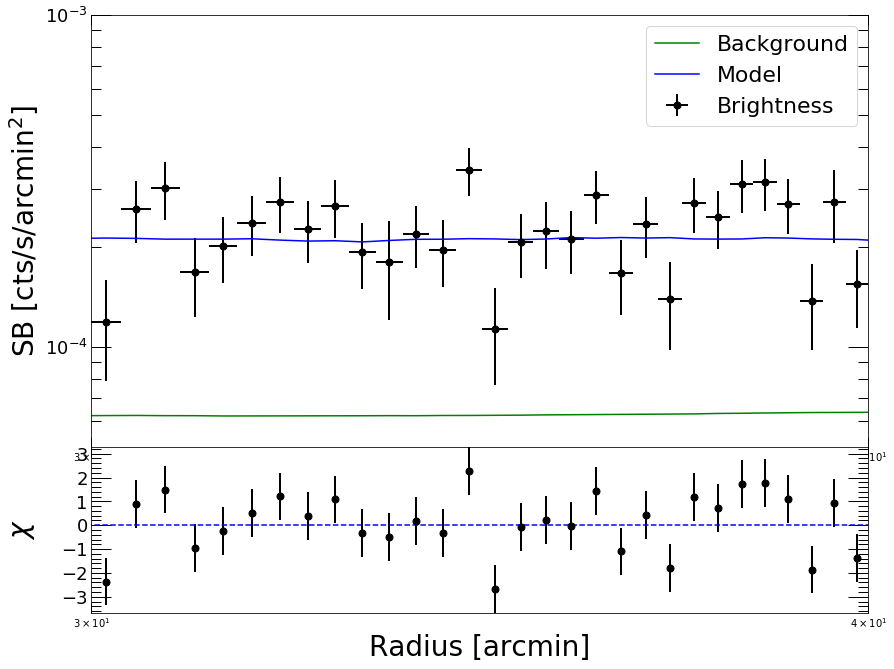

In [16]:
prof.Plot(model=mod, axes=[30., 40., 5e-5, 1e-3])

Now we define a new [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) object with a logarithmic binning, from which we will subtract the fitted background

In [17]:
prof2 = pyproffit.Profile(dat, center_choice='peak', binsize=30, maxrad=30., binning='log')

prof2.SBprofile()

prof2.Backsub(fitconst)

Determining X-ray peak
Coordinates of surface-brightness peak: 272.0 281.0
Corresponding FK5 coordinates:  55.72147733144434 -53.628226297404545


<Figure size 432x288 with 0 Axes>

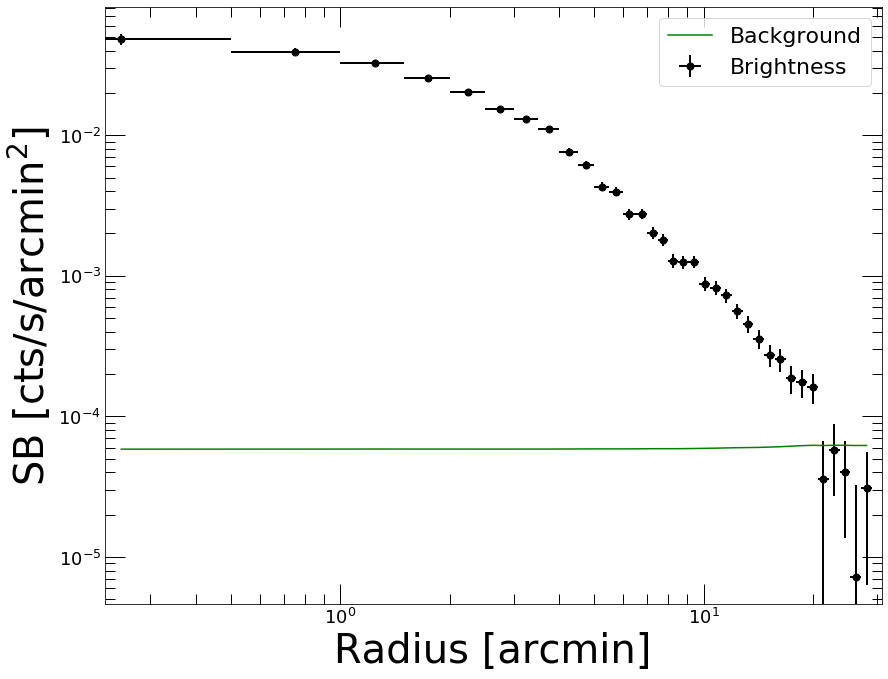

In [18]:
prof2.Plot()

Now we are ready to define a new [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) object and apply the [OnionPeeling](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.OnionPeeling) method,

In [19]:
depr_op = pyproffit.Deproject(profile=prof2, cf=cf, z=z_a3158)

depr_op.OnionPeeling()

<Figure size 432x288 with 0 Axes>

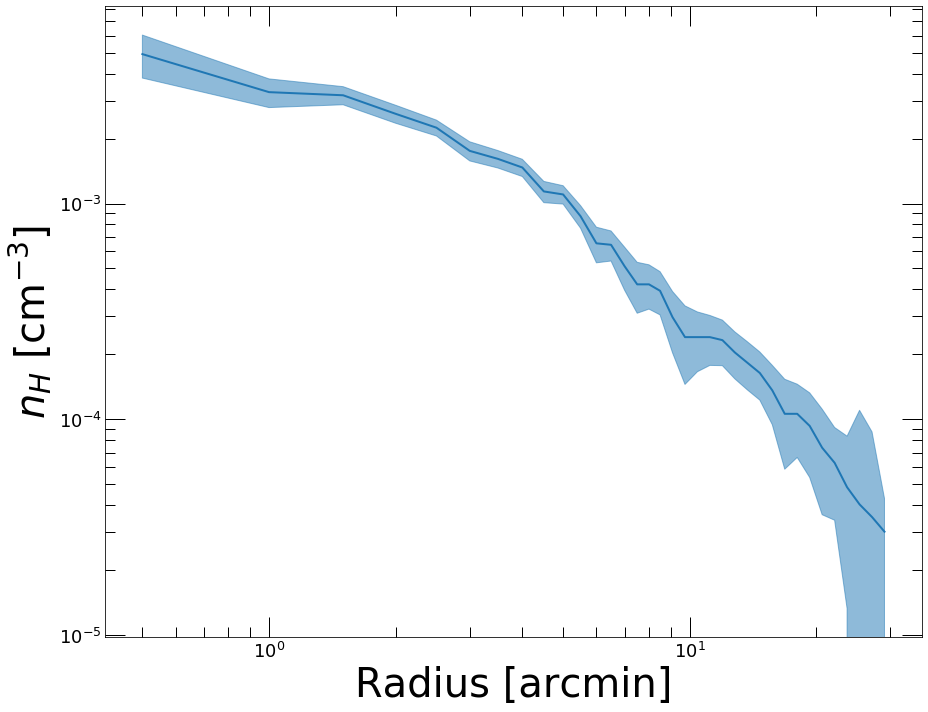

In [20]:
depr_op.PlotDensity(xscale='arcmin')

Clearly we want to know how the two methods compare. The [plot_multi_methods](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.plot_multi_methods) function allows the user to easily compare the results of several density profile reconstructions

Showing 2 density profiles


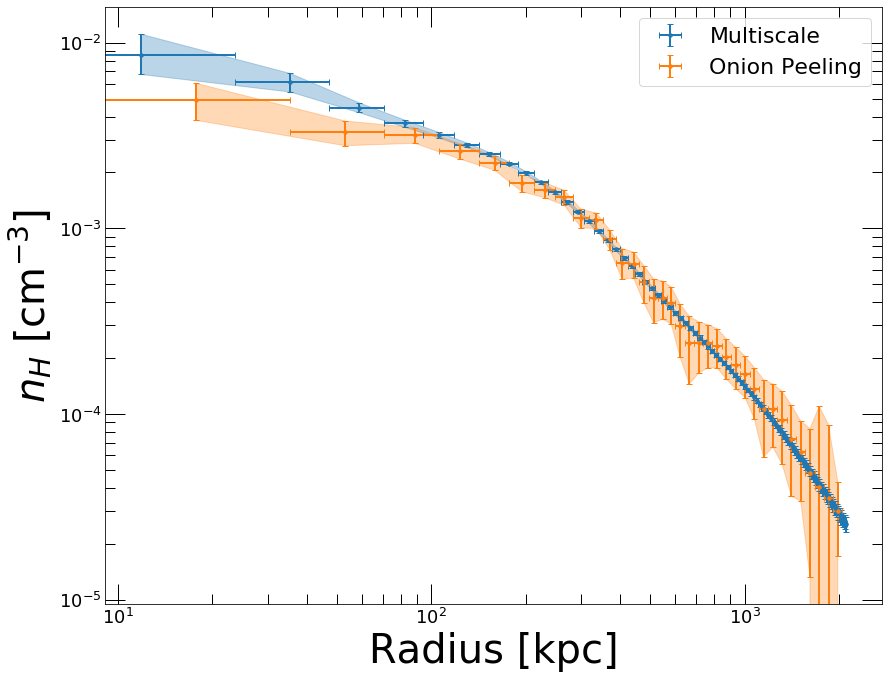

In [21]:
outfig = pyproffit.plot_multi_methods(deps = (depr, depr_op), 
                            profs = (prof, prof2),
                            labels = ('Multiscale', 'Onion Peeling'))

Clearly the two methods are consistent, but the [Multiscale](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Multiscale) approach is much less noisy. In the central regions we can easily notice the effect of the PSF deconvolution in the [Multiscale](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Multiscale) case; in the [OnionPeeling](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.OnionPeeling) case no PSF deconvolution can be applied.

If instead of PyMC3 one wishes to use the (usually more computationally efficient) Stan backend, it is easy to set it up when calling [Multiscale](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Data.Multiscale) by using the _backend='stan'_ option. The results of PyMC3 and Stan are usually indistinguishable.

## Gas masses ##

The gas mass profile is the integral of the gas density profile over the volume. The [Deproject](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject) class contains two methods to compute the gas mass profile and the posterior distribution of $M_{gas}$ evaluated at a specific radius. [PlotMgas](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.PlotMgas) allows the user to view the total reconstructed $M_{gas}$ profile, wherease [Mgas](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.deproject.Deproject.Mgas) computes $M_{gas}$ at any user given radius (in kpc) and plot the posterior distribution of this value.

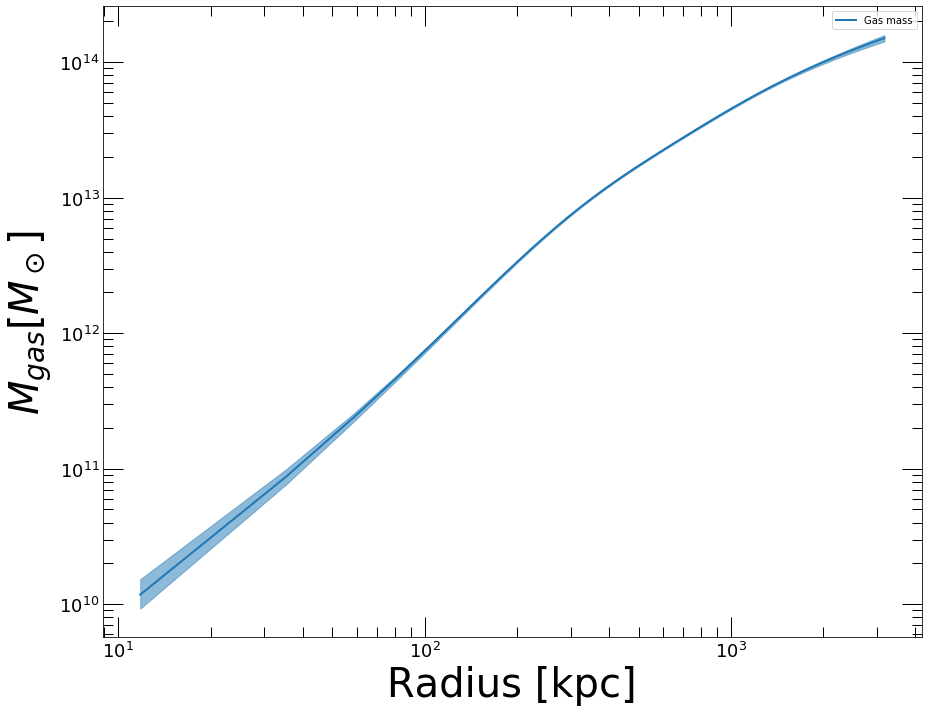

In [22]:
depr.PlotMgas()

Now let's say for instance that we want to compute $M_{gas}$ at $R_{500}=1123$ kpc,

<Figure size 432x288 with 0 Axes>

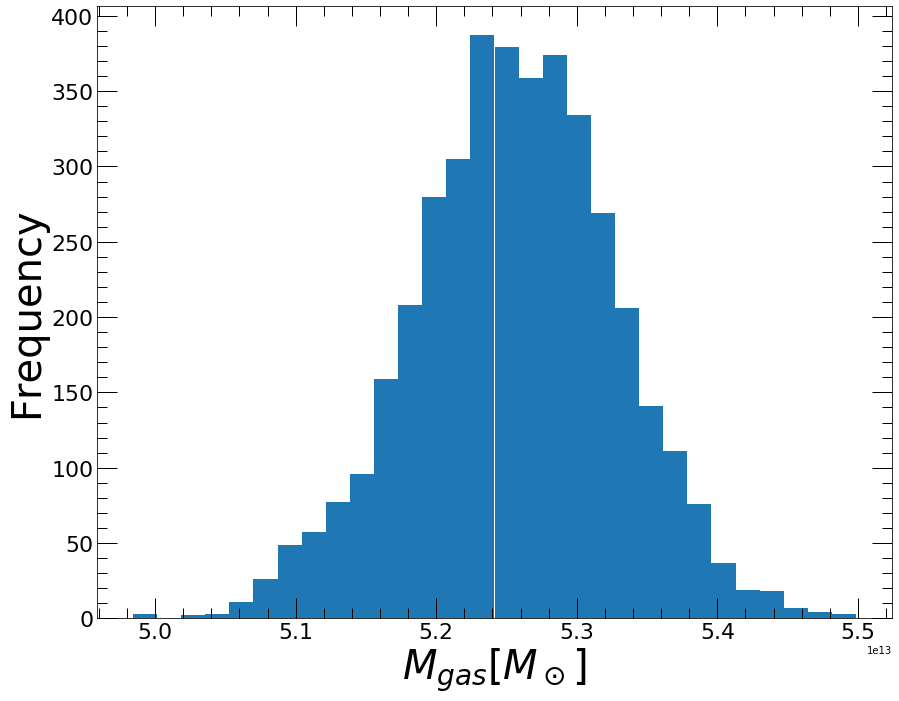

In [23]:
mg_r500, mg_lo, mg_hi = depr.Mgas(radius = 1123.)